In [1]:
import pandas as pd
import gensim
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt
from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
import numpy as np
import tqdm

In [2]:
data = pd.read_csv('scrape/restaurant-data/cleaned_restaurant_reviews.csv', index_col=0)

In [3]:
data = data.reset_index(drop=True)

In [4]:
data

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
2,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
3,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
4,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28294,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box D $13.80\n川椒雞柳 | 鮮腐竹蝦球 | 清炒西蘭花 | ...,K T,"Oct 27, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28295,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box C $11.80\n普寧豆醬走地雞 | 鮮菌翡翠豆腐 | 蒜茸炒四...,K T,"Oct 26, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28296,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box B $11.80\n蒜子豆豉凉瓜黑豬梅肉 | 香菌扒豆腐 | 蒜茸...,K T,"Oct 9, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28297,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\n潮州糜 Bento A $12.80\n鹵鴨拼豆干 | 川椒雞 | 欖菜四季苗| 菜脯...,K T,"Oct 1, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central


## New Cleaning

In [5]:
import emoji
import regex as re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

lemmatizer = WordNetLemmatizer()

In [6]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [7]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"o\'clock", "clock", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['address', 'note', 'tel', 'website', 'open', 'burpple']
add_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
    'won', "won't", 'wouldn', "wouldn't"])
add_stopwords_2 =  ['n','s','m','i','1','2','3','4','5','6','7','8','9','10','one','two',
    'it','in','ve','well','could','would','really','also','even',
    'alway','always','still','never','much','thing','yet',
    'said','asked','did','go','got','do','make','know','think','come','going',
    'put','went','seem','order','ordered','give','eat','make','get']

stopwords.extend(new_stopwords)
stopwords.extend(add_stopwords)
stopwords.extend(add_stopwords_2)

In [9]:
cleaned_review_list = []
count = 0

for review in data['review']:
    # lower case
    review = review.lower()

    # deemojize
    review = emoji.demojize(review)

    # remove headers
    review = ' '.join(review.split('\n')[2:])

    # remove location (pushpin or location:)
    review = review.split('round_pushpin')[0]
    review = review.split('location:')[0]

    # clean punctuation
    review = re.sub(r'[^\w\s]', '', review)

    # tokenize
    tokens = word_tokenize(review)

    # remove stopwords and URLs
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if 'http' not in word]
    tokens = [word for word in tokens if 'www' not in word]

    # decontraction
    tokens = [decontracted(word) for word in tokens]

    ### to add in translation code... shld translate each token

    # lemmatizing ###### IDK if we shld lemmatize or not
    # POS tagging
    tokens = [nltk.pos_tag([word]) for word in tokens]
    # lemmatization
    tokens = [lemmatizer.lemmatize(word[0][0], get_wordnet_pos(word[0][1])) 
        if get_wordnet_pos(word[0][1])!=None else lemmatizer.lemmatize(word[0][0]) for word in tokens]

    # concatenate tokens back
    cleaned_review = " ".join(tokens)
    cleaned_review_list.append(cleaned_review)

    if count%1000 == 0:
        print(count)
    count+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [10]:
# replace the old cleaned text
data['cleaned_text'] = cleaned_review_list

In [33]:
restaurant_review_df = data[['url', 'cleaned_text']]
restaurant_review_df = restaurant_review_df.groupby(['url'], as_index = False).agg({'cleaned_text': ' '.join})
restaurant_review_df.head(2)

,url,cleaned_text
0,https://www.burpple.com/108-matcha-saro?bp_ref...,s850 strong matcha flavor soft serve topped wh...
1,https://www.burpple.com/136-hong-kong-street-f...,zhi char feast family love tze char lose count...


In [32]:
restaurant_characteristics_df = data.drop(['review', 'cleaned_text'], axis=1)
restaurant_characteristics_df = restaurant_characteristics_df.groupby(['url'], as_index = False).first()
restaurant_characteristics_df.head(2)

,url,name,neighbourhood,price,categories,user,date,cleaned_price,cleaned_categories,Healthy,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/108-matcha-saro?bp_ref...,108 Matcha Saro (Suntec City),Promenade,~$10/pax,"['Desserts', 'Ice Cream & Yoghurt', 'Japanese']",Stefanny Stefanny,Nov 8 at 3:09pm,10.0,"['Desserts', 'Desserts', 'Japanese']",0,...,0,0,0,0,1,0,0,0,0,South
1,https://www.burpple.com/136-hong-kong-street-f...,136 Hong Kong Street Fish Head Steamboat (Joo ...,Macpherson,~$15/pax,"['Rainy Day Comforts', 'Hawker Food', 'Hot Pot...",Spoons Of Delights,3h ago,15.0,"['Rainy Day Comforts', 'Local Delights', 'Chin...",0,...,0,0,0,0,0,0,0,0,0,East


In [34]:
restaurant_review_df = pd.merge(restaurant_review_df, restaurant_characteristics_df, on='url')

In [35]:
restaurant_review_df.head(5)

,url,cleaned_text,name,neighbourhood,price,categories,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/108-matcha-saro?bp_ref...,s850 strong matcha flavor soft serve topped wh...,108 Matcha Saro (Suntec City),Promenade,~$10/pax,"['Desserts', 'Ice Cream & Yoghurt', 'Japanese']",Stefanny Stefanny,Nov 8 at 3:09pm,10.0,"['Desserts', 'Desserts', 'Japanese']",...,0,0,0,0,1,0,0,0,0,South
1,https://www.burpple.com/136-hong-kong-street-f...,zhi char feast family love tze char lose count...,136 Hong Kong Street Fish Head Steamboat (Joo ...,Macpherson,~$15/pax,"['Rainy Day Comforts', 'Hawker Food', 'Hot Pot...",Spoons Of Delights,3h ago,15.0,"['Rainy Day Comforts', 'Local Delights', 'Chin...",...,0,0,0,0,0,0,0,0,0,East
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,four hand dinner chef alvin chef jay legendary...,15 Stamford by Alvin Leung,City Hall,~$60/pax,"['Local Delights', 'Date Night', 'Seafood', 'S...",Xiao Fei,11m ago,60.0,"['Local Delights', 'Date Night', 'Seafood', 'W...",...,1,0,0,0,0,0,0,0,0,Central
3,https://www.burpple.com/25-degrees-singapore?b...,oh yesh loveeeee burger goooooood locate hotel...,25 Degrees Singapore,Bras Basah,~$20/pax,"['Late Night', 'Burgers', 'Supper', 'Western',...",Jaren Ng,Mar 5 at 12:30pm,20.0,"['Supper', 'Western', 'Supper', 'Western', 'Dr...",...,1,0,0,0,0,0,1,0,0,Central
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,signature firebird koreaninspired sandwich fry...,46 Mittsu,Outram Park,~$15/pax,"['Breakfast & Brunch', 'Sandwiches', 'Salads',...",Jessica Chew,9m ago,15.0,"['Breakfast & Brunch', 'High Tea', 'Breakfast ...",...,1,0,0,0,0,0,0,1,0,Central


## LDA

In [36]:
# create dictionary
docs = restaurant_review_df['cleaned_text']
processed_docs = [d.split() for d in docs]
dictionary = gensim.corpora.Dictionary(processed_docs)

In [37]:
len(processed_docs)

845

In [38]:
# term document frequency
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [40]:
len(bow_corpus)

845

In [41]:
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                       id2word=dictionary,
                                       num_topics=10,
                                       alpha=0.1, # document topic density. higher alpha, documents composed of more topics
                                       eta=0.01, # topic word density. higher beta, topics composed of large number of words in the corpus
                                       chunksize=100, # number of documents to consider at once
                                       passes=10, # number of times to go through the entire corpus
                                       random_state =100)

In [42]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.010*"pasta" + 0.008*"dish" + 0.008*"good" + 0.008*"sauce" + 0.007*"taste" '
  '+ 0.007*"flavour" + 0.006*"rice" + 0.005*"like" + 0.005*"food" + '
  '0.005*"salmon"'),
 (1,
  '0.011*"chicken" + 0.009*"sauce" + 0.009*"fry" + 0.008*"dish" + '
  '0.006*"flavour" + 0.006*"good" + 0.006*"rice" + 0.005*"taste" + '
  '0.005*"sweet" + 0.005*"serve"'),
 (2,
  '0.011*"prawn" + 0.008*"flavour" + 0.007*"taste" + 0.007*"good" + '
  '0.006*"noodle" + 0.006*"dish" + 0.006*"like" + 0.006*"pork" + 0.005*"serve" '
  '+ 0.005*"sweet"'),
 (3,
  '0.013*"tea" + 0.006*"sweet" + 0.006*"good" + 0.006*"cream" + 0.005*"taste" '
  '+ 0.005*"dish" + 0.005*"like" + 0.005*"afternoon" + 0.004*"set" + '
  '0.004*"bowl"'),
 (4,
  '0.011*"egg" + 0.010*"good" + 0.008*"like" + 0.007*"bread" + 0.007*"pork" + '
  '0.007*"taste" + 0.006*"sauce" + 0.006*"try" + 0.006*"dish" + '
  '0.005*"flavour"'),
 (5,
  '0.010*"noodle" + 0.010*"pork" + 0.009*"rice" + 0.008*"dish" + 0.008*"soup" '
  '+ 0.008*"good" + 0.008*"fry" + 

In [43]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
lda_score = coherence_model_lda.get_coherence()
lda_score

0.31804833792287174

In [44]:
def compute_coherence_values(k):
    
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           alpha=0.1, # document topic density. higher alpha, documents composed of more topics
                                           eta=0.01, # topic word density. higher beta, topics composed of large number of words in the corpus
                                           chunksize=100, # number of documents to consider at once
                                           passes=10, # number of times to go through the entire corpus
                                           random_state =100)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [45]:
# grid = {}
# grid['Validation_Set'] = {}

# # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)

# # Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')

# # Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')


# model_results = {
#                  'Topics': [],
#                  'Alpha': [],
#                  'Beta': [],
#                  'Coherence': []
#                 }

# # Can take a long time to run
# if 1 == 1:
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)))
    
#     # iterate through number of topics
#     for k in topics_range:
#         # iterate through alpha values
#         for a in alpha:
#             # iterare through beta values
#             for b in beta:
#                 # get the coherence score for the given parameters
#                 cv = compute_coherence_values(k=k, a=a, b=b)
#                 # Save the model results
#                 model_results['Topics'].append(k)
#                 model_results['Alpha'].append(a)
#                 model_results['Beta'].append(b)
#                 model_results['Coherence'].append(cv)
                
#                 pbar.update(1)
#     pd.DataFrame(model_results).to_csv('restaurant_lda_tuning_results.csv', index=False)
#     pbar.close()

In [46]:
# iterate through number of topics
coherence_values = []
topics_range = range(2,11,1)

for k in topics_range:
    value = compute_coherence_values(k)
    print(k)
    print(value)
    coherence_values.append(value)

2
0.32108819932159033
3
0.3089515104691282
4
0.32808673620655604
5
0.30178412256965637
6
0.33741894570673875
7
0.3316808192512459
8
0.3223307679581065
9
0.316250749389001
10
0.31804833792287174


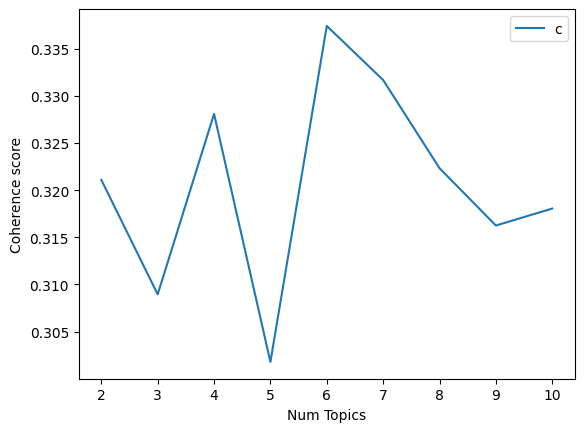

In [47]:
# Show graph
plt.plot(topics_range, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [75]:
# optimal parameters
num_topics = 3 ### CHANGE THIS

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                        id2word=dictionary,
                                        num_topics=num_topics,
                                        alpha=0.1, # document topic density. higher alpha, documents composed of more topics
                                        eta=0.01, # topic word density. higher beta, topics composed of large number of words in the corpus
                                        chunksize=100, # number of documents to consider at once
                                        passes=10, # number of times to go through the entire corpus
                                        random_state =100)
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[bow_corpus]

[(0,
  '0.008*"good" + 0.008*"taste" + 0.006*"like" + 0.006*"dish" + '
  '0.006*"flavour" + 0.006*"cream" + 0.006*"pasta" + 0.006*"sweet" + '
  '0.005*"sauce" + 0.005*"try"'),
 (1,
  '0.008*"sauce" + 0.008*"dish" + 0.008*"fry" + 0.007*"chicken" + 0.007*"good" '
  '+ 0.006*"taste" + 0.006*"rice" + 0.006*"like" + 0.006*"pork" + '
  '0.005*"flavour"'),
 (2,
  '0.008*"good" + 0.008*"taste" + 0.008*"like" + 0.008*"flavour" + '
  '0.007*"sweet" + 0.006*"try" + 0.006*"egg" + 0.005*"cream" + 0.005*"pork" + '
  '0.004*"noodle"')]


In [76]:
# Visualize the topics 
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('restaurant_ldavis_prepared_'+str(num_topics)+'_12apr_final')
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'restaurant_ldavis_prepared_'+ str(num_topics) +'_12apr_final.html')
LDAvis_prepared

### https://we1s.ucsb.edu/research/we1s-tools-and-software/topic-model-observatory/tmo-guide/tmo-guide-pyldavis/
# A “relevance metric” slider scale at the top of the right panel controls how the words for a topic are sorted.
# lambda 1: sorts words by their frequency in the topic (red bars)
# lambda 0: sorts words by their "lift". Words whose red bars are nearly as long as their blue bars will be at the top Lift means how much a word's frequency sticks out in a topic above the baseline of its overall frequency in the model

/Users/natalie/opt/anaconda3/envs/bt4221/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.051772 -0.008096       1        1  41.195595
2      0.034541 -0.032275       2        1  33.768106
0      0.017232  0.040370       3        1  25.036299, topic_info=           Term         Freq        Total Category  logprob  loglift
2061      pasta  2087.000000  2087.000000  Default  30.0000  30.0000
102       cream  4013.000000  4013.000000  Default  29.0000  29.0000
2542      pizza  1052.000000  1052.000000  Default  28.0000  28.0000
79    chocolate  2275.000000  2275.000000  Default  27.0000  27.0000
823   croissant  1034.000000  1034.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
342       price   844.178436  2921.491928   Topic3  -5.7930   0.1434
496       worth   763.526899  2360.926074   Topic3  -5.8934   0.2560
457        time   867.962979  3468.195045   Topic3  -5.7652  -0.0004
74       cheese   884.244822  3762.941201   Topic3  -5.7466  -0.0634
260        make   853.822592  3328.495254   Topic3  -5.7816   0.0243

[395 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
26811      1  0.971045        1946
1208       1  0.309645       1for1
1208       2  0.148254       1for1
1208       3  0.540472       1for1
8623       1  0.887596        2023
...      ...       ...         ...
31705      2  1.028762       𝙎𝙝𝙖𝙗𝙪
31706      2  1.028636      𝙎𝙤𝙩𝙤𝙣𝙜
31707      2  1.028727      𝙏𝙤𝙗𝙞𝙠𝙤
26788      1  0.950462  𝙑𝙞𝙚𝙩𝙣𝙖𝙢𝙚𝙨𝙚
26788      2  0.041324  𝙑𝙞𝙚𝙩𝙣𝙖𝙢𝙚𝙨𝙚

[711 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [77]:
# allocate each restaurant to a topic
topics = []
for topic_bow in bow_corpus:
    topic_prob_list = sorted(lda_model.get_document_topics(topic_bow), key=lambda tup:tup[1], reverse=True)
    highest_prob_topic = topic_prob_list[0][0]
    topics.append(highest_prob_topic)

In [78]:
restaurant_review_df['topics'] = topics

print(restaurant_review_df['topics'].value_counts())

restaurant_review_df_encoded = restaurant_review_df.drop(['name', 'cleaned_text', 'price', 'categories', 'user', 'date', 'cleaned_categories'], axis=1)

# one hot encode region & topics
region_dummies = pd.get_dummies(restaurant_review_df_encoded['region'])
neighbourhood_dummies = pd.get_dummies(restaurant_review_df_encoded['neighbourhood'])
topic_dummies = pd.get_dummies(restaurant_review_df_encoded['topics'])

restaurant_review_df_encoded = restaurant_review_df_encoded.drop(['region', 'neighbourhood', 'topics'], axis=1)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(region_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(neighbourhood_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(topic_dummies)

restaurant_review_df_encoded.to_csv('lda_labelled_restaurants_' + str(num_topics) + '_12apr_final.csv') 

1    363
2    278
0    204
Name: topics, dtype: int64
